# One Neuron Model.
Simple linear classifier.

# Libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import requests
from pathlib import Path
from tqdm.auto import tqdm

## GPU check

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Model training on: {device}")

Model training on: cuda


# Dataset loading

In [3]:
train_data = datasets.MNIST(
    root= "MNIST_Data/train/",
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root= "MNIST_Data/test/",
    train= False,
    download= True,
    transform= ToTensor(),
    target_transform = None
)

In [4]:
print(f"Train Data:{len(train_data)}, Test Data:{len(test_data)}")

Train Data:60000, Test Data:10000


In [5]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

## Plotting demo data

Text(0.5, 1.0, 'Given Label: 9')

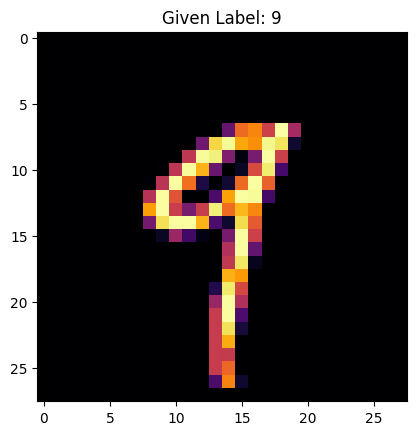

In [6]:
demo = int(random.random()*10000)       # generating random image to show
# print(demo)

image,label = train_data[demo]
plt.imshow(image.squeeze(), cmap="inferno")
plt.title(f"Given Label: {label}")

# Dataloader

In [7]:
batch_size = 32

train_Dataloader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)

test_Dataloader = DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

# Model

In [8]:
class single_Neuron(nn.Module):
    def __init__(self, input, output, hidden):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features = output)
        )

    def forward(self,x):
        return self.layer_stack(x)

In [9]:
model = single_Neuron(
    input = 784,        # 28*28*1 = 784
    hidden = 2,
    output = len(train_data.class_to_idx)
).to(device)

print(model)

single_Neuron(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)


C:\Users\niloy\anaconda3\envs\pytorch1.13\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
model.state_dict()

OrderedDict([('layer_stack.1.weight', <UninitializedParameter>),
             ('layer_stack.1.bias', <UninitializedParameter>)])

In [11]:
# Helper functions from daniel bourke

if Path("helper_functions.py").is_file():
    print("Python script already downloaded")
else:
    print("Downloading helper_functions.py script")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

Python script already downloaded


In [12]:
from helper_functions import accuracy_fn, print_train_time
from timeit import default_timer as timer

# Loss Function and Optimizer

faster learning rate => less accurate results
slower learning rate => more accurate results

In [13]:
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params= model.parameters(),
    lr = learning_rate
)

# Training the Model

In [20]:
start_timer =timer()
epochs = 10

for e in range(epochs):
    print(f"Epoch: {e}")
    train_loss = 0

    # Load the data in batches to avoid memory problems
    for batch, (X,y) in enumerate(train_Dataloader):
        X,y = X.to(device), y.to(device)    # training data

        model.train()                       # model starts training
        y_pred = model(X)                   # forward pass
        loss = loss_fn(y_pred,y)            # calculating loss
        train_loss += loss                  # accumulate loss
        optimizer.zero_grad()               # clearing gradients

        loss.backward()                     # back propagation
        optimizer.step()                    # single optimization step
    train_loss /= len(train_Dataloader)     # loss across all data

    # Test the model on unseen data
    test_loss, test_acc = 0,0
    model.eval()

    """
    InferenceMode is a new context manager analogous to no_grad to be used when
    you are certain your operations will have no interactions with autograd (e.g., model training).
    """

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_Dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model(X_test)                   # model predicting on test data
            test_loss += loss_fn(test_pred, y_test)     # Calculate loss and accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate loss and accuracy
        test_loss /= len(test_Dataloader)
        test_acc /= len(test_Dataloader)

    print(f"Train loss: {train_loss:.2f} | Test loss: {test_loss:.2f} | Accuracy: {test_acc:.2f}\n")

    # Stop timer
    end_timer = timer()
    # Calculate timer difference
    total_train_time_model = print_train_time(start=start_timer,
                                              end=end_timer,
                                              device=str(next(model.parameters()).device))

Epoch: 0
Train loss: 0.32 | Test loss: 0.30 | Accuracy: 91.71


Train time on cuda:0: 10.248 seconds
Epoch: 1
Train loss: 0.31 | Test loss: 0.30 | Accuracy: 91.78


Train time on cuda:0: 20.844 seconds
Epoch: 2
Train loss: 0.31 | Test loss: 0.30 | Accuracy: 91.84


Train time on cuda:0: 31.001 seconds
Epoch: 3
Train loss: 0.31 | Test loss: 0.30 | Accuracy: 91.68


Train time on cuda:0: 41.082 seconds
Epoch: 4
Train loss: 0.30 | Test loss: 0.29 | Accuracy: 91.88


Train time on cuda:0: 51.237 seconds
Epoch: 5
Train loss: 0.30 | Test loss: 0.29 | Accuracy: 91.84


Train time on cuda:0: 61.667 seconds
Epoch: 6
Train loss: 0.30 | Test loss: 0.29 | Accuracy: 91.88


Train time on cuda:0: 72.059 seconds
Epoch: 7
Train loss: 0.30 | Test loss: 0.29 | Accuracy: 91.99


Train time on cuda:0: 82.559 seconds
Epoch: 8
Train loss: 0.30 | Test loss: 0.29 | Accuracy: 92.04


Train time on cuda:0: 92.756 seconds
Epoch: 9
Train loss: 0.29 | Test loss: 0.29 | Accuracy: 92.04


Train time on cuda:0: 103.1

# Predicting Random Image

In [15]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

# Plotting Prediction

In [16]:
# function to plot predictions
def plot_prediction(test_samples, test_lables):
    plt.figure(figsize=(20,8))
    n_rows = 2
    n_cols = 5

    for i, sample in enumerate(test_samples):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(sample.squeeze(), cmap="inferno")

        pred_label = train_data.classes[pred_classes[i]]
        truth_label = train_data.classes[test_lables[i]]

        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text,fontsize=10, c = "g")
        else:
            plt.title(title_text, fontsize=10, c = "r")

        plt.axis(False)

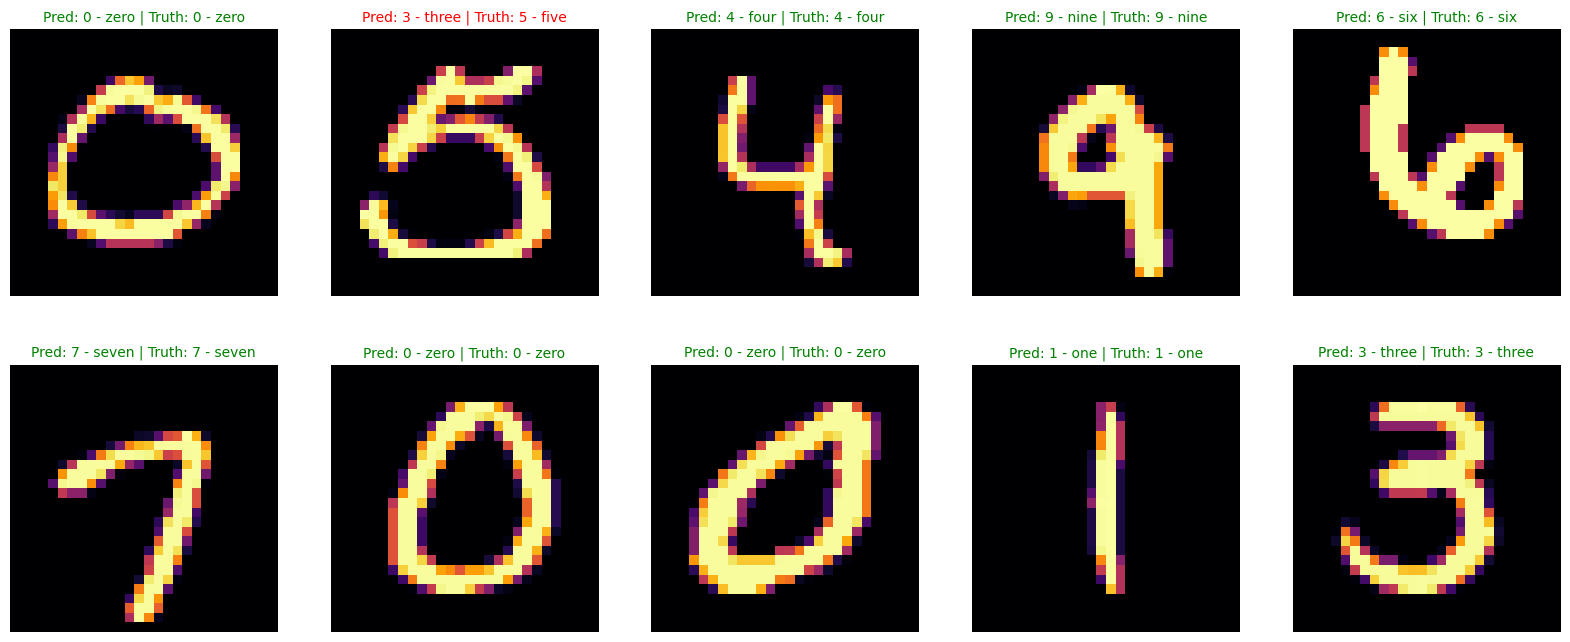

In [17]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 10):
    test_samples.append(sample)
    test_labels.append(label)

    pred_probs = make_predictions(model=model, data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

# Make Predictions
plot_prediction(test_samples, test_labels)